In [6]:
from NotebookLib import *
import GateSimulation_In_Between
GateSimulation  = reload(GateSimulation_In_Between)
sim = GateSimulation.Simulation('O-x-O')

Initializing system O-x-O ...
Constructing states and excitations ...
Constructing ground and first-excited statespace ...
Constructing gs_hamiltonian ...
Constructing e1_hamiltonian ...
Constructing interactions V_plus and V_minus ...
Constructing NJ_hamiltonian ...
Inverting NJ_hamiltonian ...
Constructing eff_hamiltonian and effective lindblad operators ...

System  O-x-O  initialized in 34.1 seconds.

Preparing Superoperator sub-class
Preparing Analytical sub-class

Done!


# Obtain grid(s) of performance

In [7]:
# Global Parameters 
kSweep = [0.995]   #[0.995]
CSweep = [50]     #[20,25,30]
SplitSweep = [8,9,10,11,20,30]

# Dimensions of first grid for optimization  --- Give odd numbers
#DeNum = 3
DENum = 151
tgNum = 2
rotNum = 3  

# Limits of the grid
## DE will be multiplied by  np.sqrt(C_val)/gamma_val
DE_min = 0.01 
DE_max = 2
tg_min = 0.95
tg_max = 1.05
rot_min = 0.98
rot_max = 1.02

## Using analytical

In [8]:
gamma_val = sim.parameters['gamma']

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)
CurrentNumberOfSimulations = 1
for (k, C_val , max_split) in AllParams:
    print(f'Simulating {CurrentNumberOfSimulations} out of {len(AllParams)}')
    #progressBar(CurrentNumberOfSimulations, TotalParamElems, barLength = 60)
    CurrentNumberOfSimulations +=1
    
    c_val = k/ (4-4*k)
    # Optimization Parameters  --- Give odd numbers
    # DE
    DESweep = np.linspace(DE_min , DE_max , num = DENum) * np.sqrt(C_val)/gamma_val
    # GateTime
    tgSweep = np.linspace(tg_min,tg_max , num = tgNum)
    # Rotations
    #r1Sweep = np.linspace(rot_min,rot_max , num = rotNum)
    #r2Sweep = np.linspace(rot_min,rot_max , num = rotNum)

    ParamsSweep = [DESweep,tgSweep ]
    ResultsShape = tuple([np.shape(param)[0] for param in ParamsSweep])

    Psucc = np.zeros(ResultsShape)
    Fidelity =  np.zeros(ResultsShape)
    GateTime =  np.zeros(ResultsShape)
    Concurrence =  np.zeros(ResultsShape)
    Rotations =  np.zeros(ResultsShape,dtype=tuple)
    sim.Analytical.obtain_gate_performance_hardware(C_val,c_val,max_split)


    def simulation_process(DE_val,tg_ratio):#,r1_ratio,r2_ratio ):
        
        jj = np.where( DESweep == DE_val)[0][0]
        kk = np.where( tgSweep == tg_ratio)[0][0]
        #ll = np.where( r1Sweep == r1_ratio)[0][0]
        #mm = np.where( r2Sweep == r2_ratio)[0][0]
        index = (jj , kk)#, ll ,mm )
        
        #Note that this line is false
        tg_ratio =1

        gate_time = sg.real( sim.Analytical.gate_time_hw.subs(   DE=DE_val,tgr = tg_ratio ) )
        p_success = sg.real(sim.Analytical.p_success_hw.subs(  DE=DE_val, tgr = tg_ratio,tgs=gate_time))
        '''try:    
            fidelity = sg.real(sim.Analytical.fidelity_hw.subs(  DE=DE_val, c=c_val,tgr = tg_ratio,tgs=gate_time,pss=p_success\
                ,r1r= r1_ratio , r2r = r2_ratio ))
            
        except ValueError:
            fidelity = 0'''
        #ket_vector = sim.Analytical.PureEvolutionVectorSg.column().subs(De=De_val,DE=DE_val,pss=p_success,tgs = gate_time )
        #concurrence = GateSimulation.concurrence_from_ket( ket_vector )

        #rotations = (complex(sim.Analytical.r1.subs( De=De_val,  DE=DE_val,tgr = tg_ratio,tgs = gate_time )) \
        #    , complex(sim.Analytical.r2.subs( De=De_val,  DE=DE_val,tgr = tg_ratio,tgs = gate_time )) )
        
        return gate_time , p_success , index

    
    all_sweeps = product(DESweep,tgSweep)#,r1Sweep,r2Sweep)
    len_all_sweeps = DENum*tgNum#*rotNum*rotNum
    with mp.Pool() as pool:
        for (tg, ps, index) in  tqdm.tqdm(pool.istarmap(simulation_process, all_sweeps),total=len_all_sweeps):
        #for (tg, ps,fid, index) in pool.starmap(simulation_process,all_sweeps):
            GateTime[index] = tg
            Psucc[index] = ps
            #Fidelity[index] = fid
            #Concurrence[index] = con
            #Rotations[index] = rot
   
 
    Directory = f'OptimizationResults/Analytical/ResC{C_val}_k{k}_Spl{max_split}_E{DENum}_t{tgNum}'
    if not os.path.exists(Directory):
        os.makedirs(Directory)
    np.save(Directory+f'/Fidelity',Fidelity)
    np.save(Directory+f'/GateTime',GateTime)
    np.save(Directory+f'/Psucc',Psucc)
    clear_output(wait=True)
    #np.save(Directory+f'/Concurrence',Concurrence)

Simulating 6 out of 6


100%|██████████| 302/302 [00:01<00:00, 185.76it/s]


## Using superoperator simulations

In [ ]:
realistic_simulation = True

gamma_val = sim.parameters['gamma']

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)
CurrentNumberOfSimulations = 0
for (k, C_val , max_split) in AllParams:
    #progressBar(CurrentNumberOfSimulations, TotalParamElems, barLength = 60)
    CurrentNumberOfSimulations +=1
    
    c_val = k/ (4-4*k)
    # Optimization Parameters  --- Give odd numbers

    # DE 
    DESweep = np.linspace(DE_min , DE_max , num = DENum) * np.sqrt(C_val)/gamma_val
    # GateTime

    tgSweep = np.linspace(tg_min,tg_max , num = tgNum)

    ParamsSweep = [DESweep,tgSweep ]
    ResultsShape = tuple([np.shape(param)[0] for param in ParamsSweep])

    Psucc = np.zeros(ResultsShape)
    Fidelity =  np.zeros(ResultsShape)
    GateTime =  np.zeros(ResultsShape)
    Concurrence = np.zeros(ResultsShape)


    def simulation_process(DE_val,tg_ratio ):
        
        
        jj = np.where( DESweep == DE_val)[0][0]
        kk = np.where( tgSweep == tg_ratio)[0][0]
        index = ( jj , kk)
        

        super_cooperativities_dict = {'C' : C_val ,'c': c_val }
        super_tg_rots_dict = {'tgr': tg_ratio, 'r1r':1 , 'r2r':1}
        
        super_detunings_dict_p = {'De':  DE_val + max_split/2 ,'De0':  DE_val - max_split/2,
                                  'DE':  DE_val,  'dc': DE_val ,'db':  DE_val }
        
        super_detunings_dict_m = {'De': -DE_val + max_split/2 ,'De0': -DE_val - max_split/2,
                                  'DE': -DE_val,  'dc': -DE_val ,'db': -DE_val }


        performance = sim.Superoperator.Simulate(super_cooperativities_dict , super_tg_rots_dict, 
                                            super_detunings_dict_p , super_detunings_dict_m , 
                                            realistic = realistic_simulation) 
        
        gate_time = performance['gate_time']
        p_success = performance['p_success']
        fidelity = performance['fidelity']
        #concurrence = performance['concurrence']

        return gate_time , p_success , fidelity , index

    simulation_process(DESweep[0],tgSweep[0] )

    pool = mp.Pool()
    all_sweeps = product(DESweep,tgSweep)
    count_tot =  DENum * tgNum
    count = 0 
    for (tg, ps,fid, index) in pool.starmap(simulation_process,all_sweeps):
        GateTime[index] = tg
        Psucc[index] = ps
        Fidelity[index] = fid
        #Concurrence[index] = con
        
        
   
 
    Directory = f'OptimizationResults/Superoperator/ResC{C_val}_k{k}_Spl{max_split}_E{DENum}_t{tgNum}'
    if not os.path.exists(Directory):
        os.makedirs(Directory)
    np.save(Directory+f'/Fidelity',Fidelity)
    np.save(Directory+f'/GateTime',GateTime)
    np.save(Directory+f'/Psucc',Psucc)
    #np.save(Directory+f'/Concurrence',Concurrence)

# Plot result

<>:46: DeprecationWarning: invalid escape sequence \L
<>:46: DeprecationWarning: invalid escape sequence \L
<ipython-input-9-bcd4150bef6a>:46: DeprecationWarning: invalid escape sequence \L
  ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'


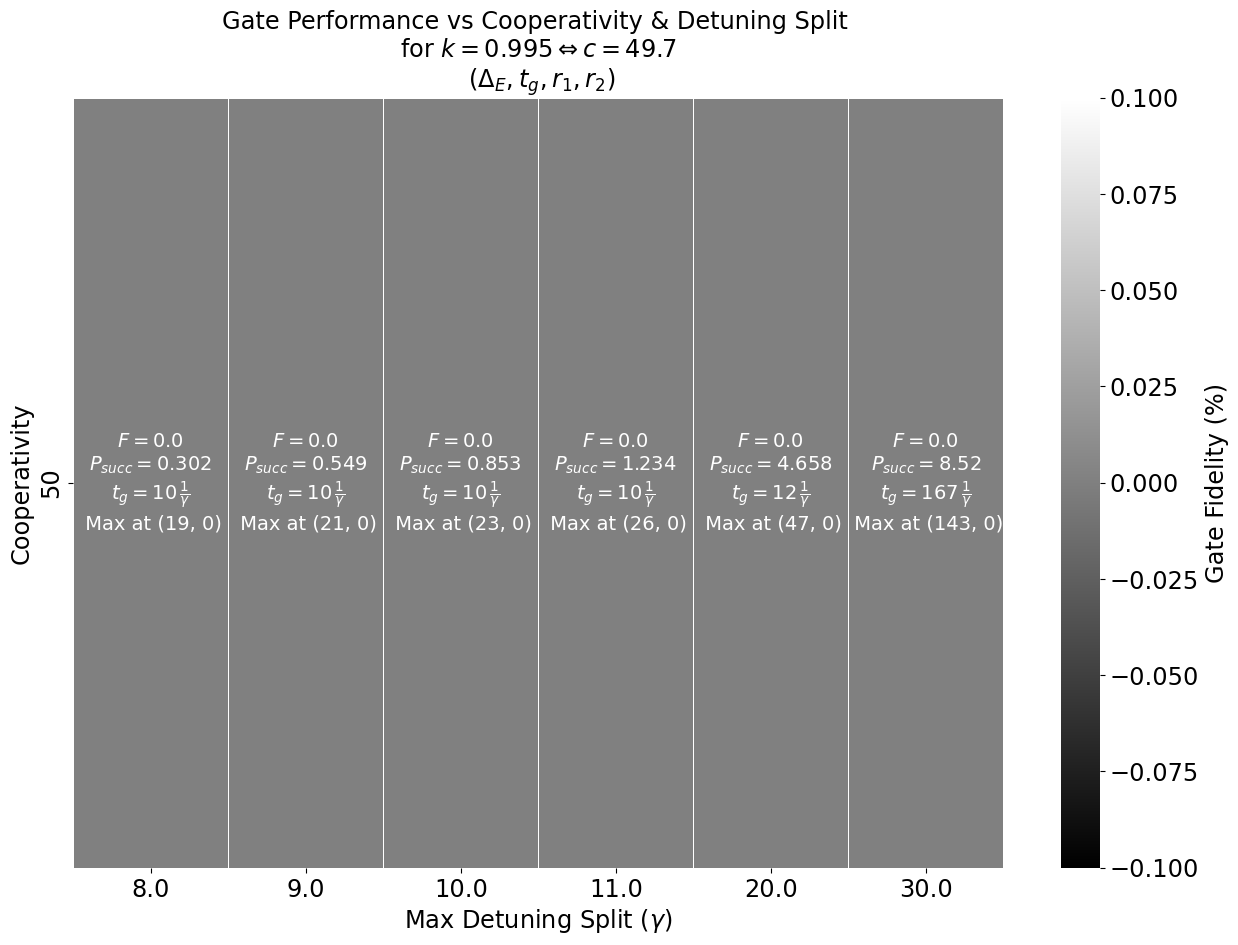

In [9]:
Analytical = True
kPlot = kSweep[0]
cPlot = kPlot / (4-4*kPlot)
'''
CSweep = [25,50,100]

SplitSweep = [3,5,10]

DeNum = 11
DENum = 11
tgNum = 11'''


if Analytical:
    subdir = 'Analytical'
else:
    subdir = 'Superoperator'
AllLabels = [["" for i in range(len(SplitSweep))]for j in range(len(CSweep))]
FidelityPlot = np.zeros(np.array(AllLabels).shape)
for (i,c) in enumerate(CSweep):
    for (j,spl) in enumerate(SplitSweep):
        DataDirectory = f'OptimizationResults/{subdir}/ResC{c}_k{kPlot}_Spl{spl}_E{DENum}_t{tgNum}/'
        GateTimeData = np.load(DataDirectory+"GateTime.npy")
        FidelityData = np.load(DataDirectory+"Fidelity.npy")
        PsuccData = np.load(DataDirectory+"Psucc.npy")
        #ConcurrenceData = np.load(DataDirectory+"Concurrence.npy")

        #argm = ArgMin( GateSimulation.gate_performance_cost_function(FidelityData,PsuccData,GateTimeData) ) #
        argm = ArgMin(- PsuccData)#ArgMin(GateTimeData/ PsuccData)
        FidelityPlot[i][j] = FidelityData[argm]

        AllLabels[i][j] += '$F='+ str(np.round(FidelityData[argm]*100,decimals=2))+r'%'+'$\n'
        AllLabels[i][j] += '$P_{succ}='+ str(np.round(PsuccData[argm]*100,decimals=3))+r'%'+'$\n'
        AllLabels[i][j] += '$t_g='+ str(int(GateTimeData[argm]))+r' \,\frac{1}{\gamma}$'
        AllLabels[i][j] += f'\n Max at {argm}'
        


fig, ax = plt.subplots()


ax = sns.heatmap(FidelityPlot*100,yticklabels=CSweep,xticklabels=SplitSweep,cmap='gray', linewidth=0.5,annot=AllLabels, fmt = ''\
    ,cbar_kws={'label': 'Gate Fidelity (%)'}, annot_kws={"size": 14}) #Greys
ax.set_ylabel('Cooperativity')
ax.set_xlabel(r'Max Detuning Split $(\gamma)$')
ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'
            +r' $(\Delta_E,t_g,r_1,r_2)$')
plt.show() 
figure = ax.get_figure()
figure.savefig(f'plots/OptimizedHeatmap.svg',transparent=False)

In [6]:
init_params = [DESweep[argm[0]],tgSweep[argm[1]]]
print(GateTimeData[argm])
print(PsuccData[argm])

10.610829997778243
0.008110729324220987


In [7]:
sim.Analytical.optimize_gate_performance_hardware(init_params[0])
print(sim.Analytical.optimized_dict)

TypeError: no canonical coercion from <class 'numpy.ndarray'> to Symbolic Ring

In [15]:
sim.Analytical.hardware_dict

{'C': 100, 'c': 249.74999999999977, 'max_split': 10}

In [14]:
sim.Analytical.gate_time_hw_full.subs( tgr = 1 , DE = float(sim.Analytical.DE_opt) )

10.610829997778243

In [13]:
sim.Analytical.p_success_hw_full.subs( tgr = 1 , DE = float(sim.Analytical.DE_opt) )

0.008110729324220994 - 9.5730939331996e-19*I

In [16]:
super = sim.Superoperator

super_variables = ['C','c','De','De0','DE','tgr','r1r','r2r']

super_dict = dict()
super_dict['De0'] =   sim.Analytical.optimized_dict['De'] - sim.Analytical.hardware_dict['max_split']
for param in super_variables:
    if param in sim.Analytical.hardware_dict:
        exec(f"super_dict['{param}'] = sim.Analytical.hardware_dict['{param}'] ")
    elif param in sim.Analytical.optimized_dict:
        exec(f"super_dict['{param}'] = sim.Analytical.optimized_dict['{param}'] ")

#super.realistic_parameters['gamma_g'] = 0.01
#super.realistic_parameters['gamma_f'] = 0.99
super.Simulate(super_dict,realistic = True)

{'fidelity': 0.9471475925835855,
 'p_success': 0.4374446295000347,
 'gate_time': 2.0975988647866375,
 'concurrence': 0.812830199036987}

In [17]:
super.performance

{'fidelity': 0.9471475925835855,
 'p_success': 0.4374446295000347,
 'gate_time': 2.0975988647866375,
 'concurrence': 0.812830199036987}

In [24]:
super.optimize_gate_performance_hardware(init_params , sim.Analytical.hardware_dict , max_iter = 10)

Cost function value: 0.05058254490031233 , fidelity=0.94942 , p_success=0.48418, tg=3.88955
Cost function value: -0.07403560481375633 , fidelity=0.95345 , p_success=0.47067, tg=3.79465
Cost function value: -0.06521402707136098 , fidelity=0.95421 , p_success=0.48091, tg=4.17403
Cost function value: -0.06503662203448551 , fidelity=0.95574 , p_success=0.46981, tg=4.08403
Cost function value: -0.07448179025294993 , fidelity=0.9549 , p_success=0.48418, tg=3.88955
Cost function value: -0.07448179025294993 , fidelity=0.95235 , p_success=0.48418, tg=3.88955
Cost function value: -0.06672473856334978 , fidelity=0.95977 , p_success=0.47181, tg=4.04206
step = 1, (De,DE,tgr,r1,r2) = [5.     4.8    0.9    0.9975 1.    ] 
Cost function value: -0.07767895231690661 , fidelity=0.95257 , p_success=0.48807, tg=3.82264
Cost function value: 0.05359897811942149 , fidelity=0.9464 , p_success=0.49824, tg=3.68049
step = 2, (De,DE,tgr,r1,r2) = [5.14   4.9344 0.8622 0.9766 1.028 ] 
Cost function value: -0.0821244

In [19]:
super.optimized_dict 

{'fidelity': 0.9508513233731039,
 'p_success': 0.48851048125750124,
 'gate_time': 3.0355387915923635,
 'tgr': 0.8606162303999991,
 'De': 5.319092480000004,
 'DE': 4.213482700799999,
 'r1r': 1.0671715712000014,
 'r2r': 1.0705384960000006}

# Tests

In [2]:
C_val = 50
c_val = C_val
max_split = 10

DE_val = 1.2*np.sqrt(C_val)

realistic = True



super_cooperativities_dict = {'C' : C_val ,'c': c_val }
super_tg_rots_dict = {'tgr': 1, 'r1r':1 , 'r2r':1}

super_detunings_dict_p = {'De':  DE_val + max_split/2 ,'De0':  DE_val - max_split/2,
                            'DE':  DE_val,  'dc': DE_val ,'db':  DE_val }

super_detunings_dict_m = {'De': -DE_val + max_split/2 ,'De0': -DE_val - max_split/2,
                            'DE': -DE_val,  'dc': -DE_val ,'db': -DE_val }
super_dict = {**super_cooperativities_dict , **super_detunings_dict_p , **super_tg_rots_dict}
sim.Superoperator.Simulate( super_cooperativities_dict , super_tg_rots_dict, super_detunings_dict_p , super_detunings_dict_m , realistic)

{'fidelity': 0.9999862909414448,
 'p_success': 5.68692477086255e-05,
 'gate_time': 590.6117279782516,
 'concurrence': 0.9999450653666694}

In [3]:
C_val = 50
c_val = C_val
max_split = 10

DE_val = 1.2*np.sqrt(C_val)

realistic = True



super_cooperativities_dict = {'C' : C_val ,'c': c_val }
super_tg_rots_dict = {'tgr': 1, 'r1r':1 , 'r2r':1}

super_detunings_dict_p = {'De':  DE_val + max_split/2 ,'De0':  DE_val - max_split/2,
                            'DE':  DE_val,  'dc': DE_val ,'db':  DE_val }

super_detunings_dict_m = {'De': -DE_val + max_split/2 ,'De0': -DE_val - max_split/2,
                            'DE': -DE_val,  'dc': -DE_val ,'db': -DE_val }
super_dict = {**super_cooperativities_dict , **super_detunings_dict_p , **super_tg_rots_dict}
sim.Analytical.obtain_gate_performance_hardware(C_val,c_val,max_split)

In [10]:

gate_time = sg.real( sim.Analytical.gate_time_hw.subs( DE=DE_val,tgr = 1 ) )
p_success = sg.real( sim.Analytical.p_success_hw.subs( DE=DE_val, tgr = 1,tgs=gate_time))
    
fidelity = sg.real(sim.Analytical.fidelity_hw.subs(   DE=DE_val, c=c_val,tgr = 1,tgs=gate_time,pss=p_success\
        ,r1r= 1 , r2r = 1 ))
print(gate_time)
print(p_success)

590.6117279782527
5.68661251992149e-05


In [16]:
for i in range(10):
    print()

False
False
False
False
False
False
True
False
False
False
